# Import

In [1]:
pip install xgboost==1.7.6

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.3/200.3 MB 10.5 MB/s eta 0:00:00
  Attempting uninstall: xgboost
    Found existing installation: xgboost 3.1.0
    Uninstalling xgboost-3.1.0:
      Successfully uninstalled xgboost-3.1.0


In [2]:
import xgboost as xgb
from xgboost.callback import EarlyStopping
from sklearn.model_selection import train_test_split

In [3]:
print(f"Versi XGBoost yang digunakan: {xgb.__version__}")

Versi XGBoost yang digunakan: 1.7.6


In [4]:
import pandas as pd
import numpy as np
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import os

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, auc

Dataset load

In [6]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
sns.set_style('whitegrid')

# Variabel untuk menyimpan nama file zip
zip_file_name = None

# Cek apakah skrip berjalan di Google Colab
try:
    from google.colab import files
    print("Lingkungan Google Colab terdeteksi. Silakan unggah file dataset Anda (format .zip)...")
    uploaded = files.upload()
    zip_file_name = list(uploaded.keys())[0]
except ImportError:
    print("Bukan lingkungan Google Colab. Pastikan file ZIP berada di folder yang sama.")
    zip_file_name = input("Masukkan nama file dataset Anda (contoh: archive.zip): ")


# Proses ekstraksi dan pemuatan data jika nama file tersedia
if zip_file_name:
    try:
        extract_dir = 'dataset_raw'
        print(f"\nMengekstrak file '{zip_file_name}'...")
        with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
            zip_ref.extractall(extract_dir)
        print("✅ Ekstraksi selesai.")

        # Otomatis menemukan file CSV di dalam direktori yang diekstrak
        csv_filename = None
        for file in os.listdir(extract_dir):
            if file.endswith(".csv"):
                csv_filename = os.path.join(extract_dir, file)
                break

        if csv_filename:
            # Muat dataset
            df = pd.read_csv(csv_filename)
            print(f"\nDataset '{os.path.basename(csv_filename)}' berhasil dimuat.")
            print("Beberapa baris pertama dari dataset:")
            print(df.head())
        else:
            print("\nError: Tidak ada file .csv yang ditemukan di dalam file ZIP.")

    except FileNotFoundError:
        print(f"\nError: File '{zip_file_name}' tidak ditemukan. Pastikan nama file benar dan berada di folder yang sama.")
    except Exception as e:
        print(f"\nTerjadi error saat memproses file: {e}")
else:
    print("\nTidak ada file yang dipilih atau nama file tidak dimasukkan. Proses dihentikan.")

Lingkungan Google Colab terdeteksi. Silakan unggah file dataset Anda (format .zip)...


Saving Fraud.csv.zip to Fraud.csv.zip

Mengekstrak file 'Fraud.csv.zip'...
✅ Ekstraksi selesai.

Dataset 'Fraud.csv' berhasil dimuat.
Beberapa baris pertama dari dataset:
   step      type   amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT  9839.64  C1231006815      170136.00       160296.36   
1     1   PAYMENT  1864.28  C1666544295       21249.00        19384.72   
2     1  TRANSFER   181.00  C1305486145         181.00            0.00   
3     1  CASH_OUT   181.00   C840083671         181.00            0.00   
4     1   PAYMENT 11668.14  C2048537720       41554.00        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155            0.00            0.00        0               0  
1  M2044282225            0.00            0.00        0               0  
2   C553264065            0.00            0.00        1               0  
3    C38997010        21182.00            0.00        1               0  
4  M1230701703

# EDA

Informasi Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB

Statistik Deskriptif:
            step      amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  \
count 6362620.00  6362620.00     6362620.00      6362620.00      6362620.00   
mean      243.40   179861.90      833883.10       855113.67      1100701.67   
std       142.33   603858.23     2888242.67      2924048.50      3399180.11   
min         1.00        0.00           0.00            0.00            0.00   
25%      

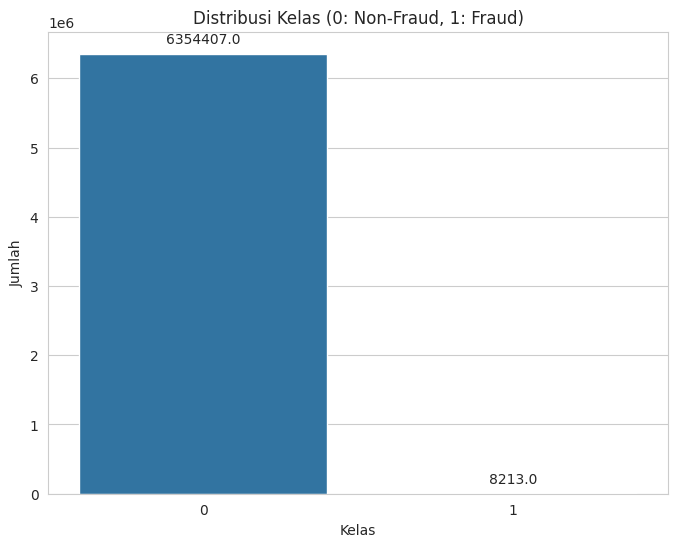

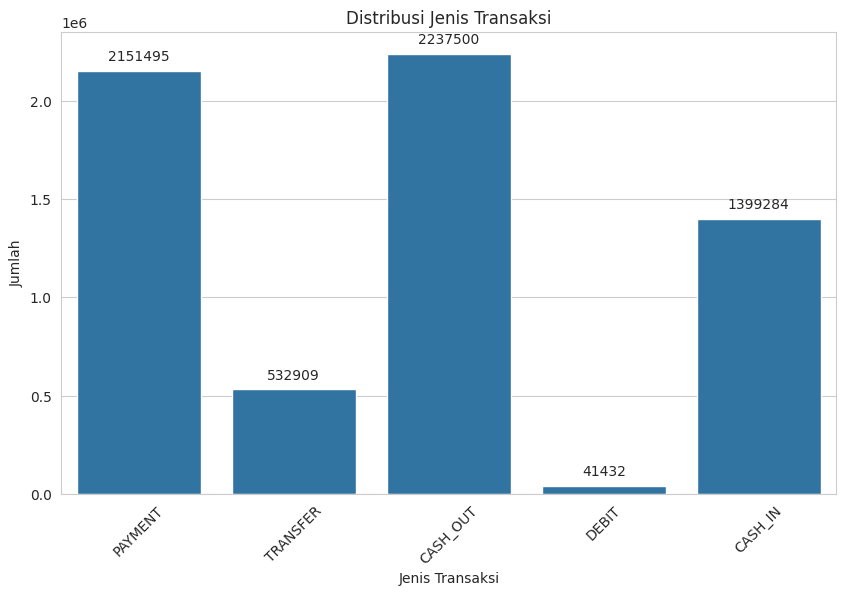


Jumlah transaksi penipuan: 8213
Jenis transaksi yang paling sering terjadi pada kasus penipuan:
type
CASH_OUT    4116
TRANSFER    4097
Name: count, dtype: int64


In [7]:
if 'df' in locals():
    print("Informasi Dataset:")
    df.info()

    print("\nStatistik Deskriptif:")
    print(df.describe())

    print("\nCek Nilai Hilang:")
    print(df.isnull().sum())

    # Visualisasi distribusi 'isFraud'
    plt.figure(figsize=(8, 6))
    ax = sns.countplot(x='isFraud', data=df)
    plt.title('Distribusi Kelas (0: Non-Fraud, 1: Fraud)')
    plt.xlabel('Kelas')
    plt.ylabel('Jumlah')
    for p in ax.patches:
        ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
    plt.show()

    # Visualisasi distribusi tipe transaksi
    plt.figure(figsize=(10, 6))
    ax = sns.countplot(x='type', data=df)
    plt.title('Distribusi Jenis Transaksi')
    plt.xlabel('Jenis Transaksi')
    plt.ylabel('Jumlah')
    plt.xticks(rotation=45)
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', xytext=(0, 10), textcoords='offset points')
    plt.show()

    # Fokus pada transaksi penipuan
    fraud_transactions = df[df['isFraud'] == 1]
    print(f"\nJumlah transaksi penipuan: {len(fraud_transactions)}")
    print("Jenis transaksi yang paling sering terjadi pada kasus penipuan:")
    print(fraud_transactions['type'].value_counts())

# Pre-Processing

In [8]:
if 'df' in locals():
    # Filter data
    df_filtered = df[df['type'].isin(['TRANSFER', 'CASH_OUT'])].copy()

    # Membuat fitur baru
    df_filtered['errorBalanceOrg'] = df_filtered['newbalanceOrig'] + df_filtered['amount'] - df_filtered['oldbalanceOrg']
    df_filtered['errorBalanceDest'] = df_filtered['oldbalanceDest'] + df_filtered['amount'] - df_filtered['newbalanceDest']

    # Memisahkan fitur dan target
    X = df_filtered.drop(['isFraud', 'nameOrig', 'nameDest', 'isFlaggedFraud'], axis=1)
    y = df_filtered['isFraud']

    # One-Hot Encoding untuk fitur 'type'
    X = pd.get_dummies(X, columns=['type'], prefix='type', drop_first=True)

    # --- PERBAIKAN ---
    # Mengubah tipe data kolom boolean menjadi integer (0 atau 1) untuk menghindari error pada SHAP
    X['type_TRANSFER'] = X['type_TRANSFER'].astype(int)

    print("Dimensi data setelah difilter dan dibuat fitur baru:")
    print(X.shape)
    print("\nContoh data setelah pra-pemrosesan:")
    print(X.head())

Dimensi data setelah difilter dan dibuat fitur baru:
(2770409, 9)

Contoh data setelah pra-pemrosesan:
    step    amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  \
2      1    181.00         181.00            0.00            0.00   
3      1    181.00         181.00            0.00        21182.00   
15     1 229133.94       15325.00            0.00         5083.00   
19     1 215310.30         705.00            0.00        22425.00   
24     1 311685.89       10835.00            0.00         6267.00   

    newbalanceDest  errorBalanceOrg  errorBalanceDest  type_TRANSFER  
2             0.00             0.00            181.00              1  
3             0.00             0.00          21363.00              0  
15        51513.44        213808.94         182703.50              0  
19            0.00        214605.30         237735.30              1  
24      2719172.89        300850.89       -2401220.00              1  


# Training XGBoost

In [9]:
if 'X' in locals() and 'y' in locals():
    # Membagi data menjadi 80% pelatihan dan 20% pengujian
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    print(f"Ukuran set pelatihan: {X_train.shape}")
    print(f"Ukuran set pengujian: {X_test.shape}")

    # Menghitung scale_pos_weight
    scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]
    print(f"\nScale Pos Weight: {scale_pos_weight:.2f}")

    # Buat callback EarlyStopping terlebih dahulu
    # save_best=True akan menyimpan model pada iterasi terbaik
    early_stop_callback = EarlyStopping(
        rounds=50,
        save_best=True
    )

    # Mendefinisikan model XGBoost dan langsung memasukkan callback
    model = xgb.XGBClassifier(
        objective='binary:logistic',
        eval_metric='aucpr',
        scale_pos_weight=scale_pos_weight,
        n_estimators=1000,
        learning_rate=0.1,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        use_label_encoder=False,
        random_state=42,
        n_jobs=-1,
        callbacks=[early_stop_callback] # Callbacks dimasukkan saat pembuatan model
    )

    # Melatih model
    print("\nMemulai pelatihan model XGBoost...")
    model.fit(
        X_train, y_train,
        eval_set=[(X_test, y_test)],
        verbose=100
    )

    # Mengambil hasil evaluasi dari riwayat pelatihan
    # Ini adalah cara yang paling andal untuk mendapatkan skor terbaik
    results = model.evals_result()
    best_score = results['validation_0']['aucpr'][model.best_iteration]

    print("\nPelatihan model selesai.")
    print(f"Iterasi terbaik: {model.best_iteration}")
    print(f"Skor terbaik (AUPRC on validation set): {best_score:.4f}")

Ukuran set pelatihan: (2216327, 9)
Ukuran set pengujian: (554082, 9)

Scale Pos Weight: 336.34

Memulai pelatihan model XGBoost...


/usr/local/lib/python3.12/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[0]	validation_0-aucpr:0.69235
[72]	validation_0-aucpr:0.99813

Pelatihan model selesai.
Iterasi terbaik: 22
Skor terbaik (AUPRC on validation set): 0.9983


# Evaluasi Model XGBoost

Cek Distribusi kelas

In [10]:
if 'y_train' in locals() and 'y_test' in locals():
    print("Distribusi kelas pada data pelatihan (y_train):")
    print(y_train.value_counts())
    print("\nDistribusi kelas pada data pengujian (y_test):")
    print(y_test.value_counts())

Distribusi kelas pada data pelatihan (y_train):
isFraud
0    2209757
1       6570
Name: count, dtype: int64

Distribusi kelas pada data pengujian (y_test):
isFraud
0    552439
1      1643
Name: count, dtype: int64


Training Evaluation

Classification Report (Train Set):

              precision    recall  f1-score   support

   Non-Fraud       1.00      1.00      1.00   2209757
       Fraud       1.00      1.00      1.00      6570

    accuracy                           1.00   2216327
   macro avg       1.00      1.00      1.00   2216327
weighted avg       1.00      1.00      1.00   2216327



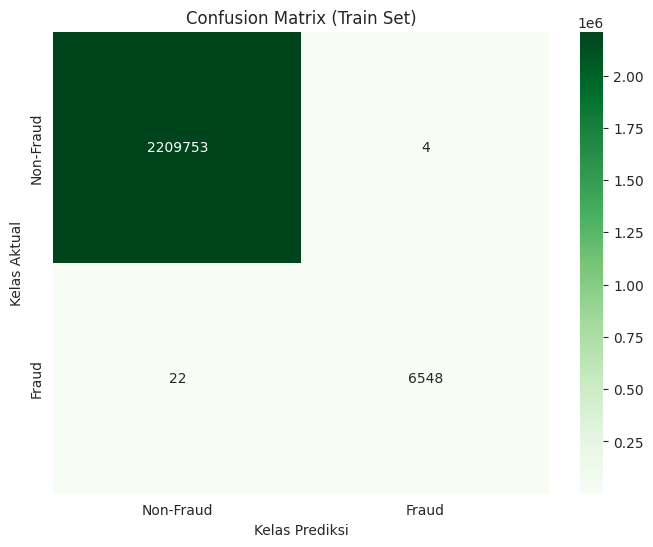

In [11]:
if 'model' in locals():
    # Membuat prediksi pada data latih
    y_pred_train = model.predict(X_train)

    # Menampilkan Classification Report untuk data latih
    print("Classification Report (Train Set):\n")
    print(classification_report(y_train, y_pred_train, target_names=['Non-Fraud', 'Fraud']))

    # Menampilkan Confusion Matrix untuk data latih
    cm_train = confusion_matrix(y_train, y_pred_train)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_train, annot=True, fmt='d', cmap='Greens', xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
    plt.title('Confusion Matrix (Train Set)')
    plt.ylabel('Kelas Aktual')
    plt.xlabel('Kelas Prediksi')
    plt.show()

Test Evaluation

Classification Report:

              precision    recall  f1-score   support

   Non-Fraud       1.00      1.00      1.00    552439
       Fraud       1.00      1.00      1.00      1643

    accuracy                           1.00    554082
   macro avg       1.00      1.00      1.00    554082
weighted avg       1.00      1.00      1.00    554082



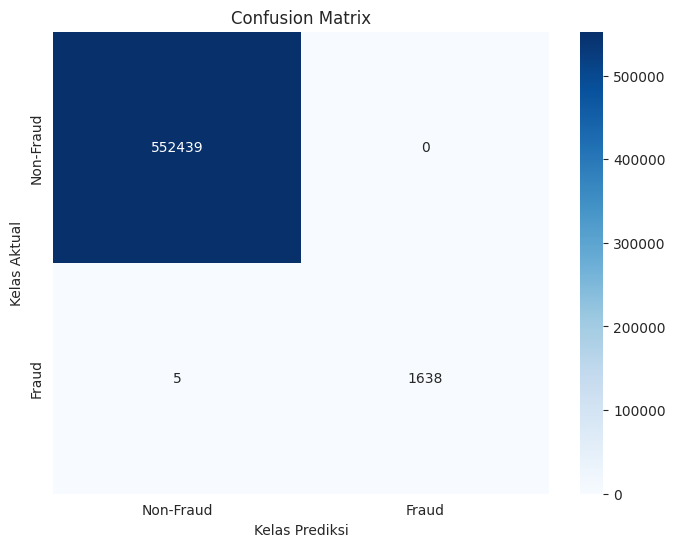


Area Under Precision-Recall Curve (AUPRC): 0.9983


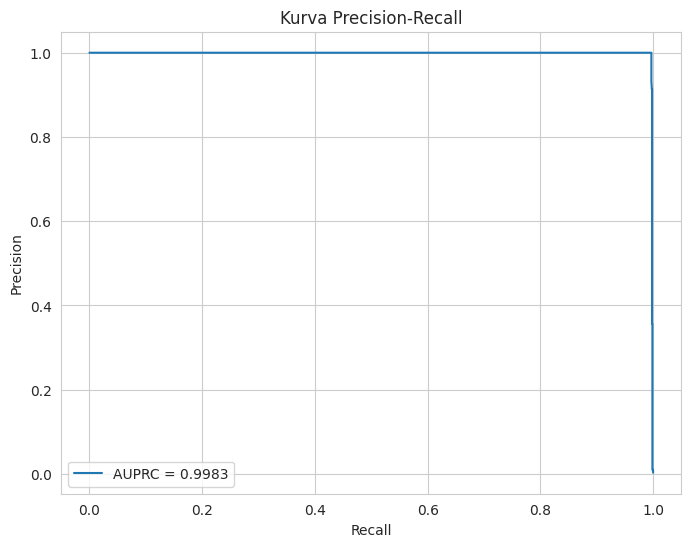

In [12]:
if 'model' in locals():
    # Membuat prediksi
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    y_pred = model.predict(X_test)

    # Menampilkan Classification Report
    print("Classification Report:\n")
    print(classification_report(y_test, y_pred, target_names=['Non-Fraud', 'Fraud']))

    # Menampilkan Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
    plt.title('Confusion Matrix')
    plt.ylabel('Kelas Aktual')
    plt.xlabel('Kelas Prediksi')
    plt.show()

    # Menghitung dan menampilkan AUPRC
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    auprc = auc(recall, precision)
    print(f"\nArea Under Precision-Recall Curve (AUPRC): {auprc:.4f}")

    # Plot kurva Precision-Recall
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label=f'AUPRC = {auprc:.4f}')
    plt.title('Kurva Precision-Recall')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(loc='best')
    plt.show()

Loss Function

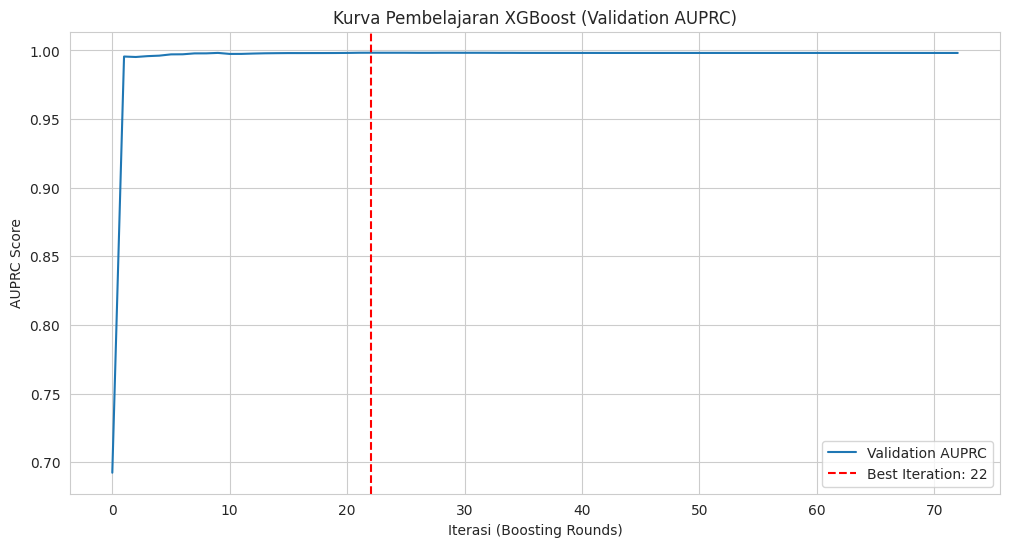

In [13]:
if 'model' in locals():
    # Mengambil riwayat hasil evaluasi dari model
    results = model.evals_result()

    # Plot kurva pembelajaran
    plt.figure(figsize=(12, 6))
    plt.plot(results['validation_0']['aucpr'], label='Validation AUPRC')
    plt.axvline(model.best_iteration, color='r', linestyle='--', label=f'Best Iteration: {model.best_iteration}')
    plt.xlabel('Iterasi (Boosting Rounds)')
    plt.ylabel('AUPRC Score')
    plt.title('Kurva Pembelajaran XGBoost (Validation AUPRC)')
    plt.legend()
    plt.grid(True)
    plt.show()

# Training Auto Encoding

In [ ]:
tensorflow_installed = False
try:
    import tensorflow as tf
    from tensorflow.keras.models import Model
    from tensorflow.keras.layers import Input, Dense
    from tensorflow.keras.callbacks import EarlyStopping as KerasEarlyStopping
    from sklearn.preprocessing import StandardScaler
    print(f"TensorFlow versi {tf.__version__} berhasil diimpor.")
    tensorflow_installed = True

except ImportError:
    print("\nError: TensorFlow tidak terinstal. Lewati sel Autoencoder.")
    print("Anda dapat menginstalnya dengan menjalankan: !pip install tensorflow")

In [ ]:
if tensorflow_installed and 'X_train' in locals():
    # 1. Scaling Data
    print("\nMenyiapkan dan men-skala data untuk Autoencoder...")
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Buat set pelatihan HANYA dari data normal
    X_train_normal_scaled = X_train_scaled[y_train == 0]
    print(f"Data latih normal (untuk AE): {X_train_normal_scaled.shape}")

    # 2. Definisikan Arsitektur Autoencoder
    input_dim = X_train_normal_scaled.shape[1]
    encoding_dim = 4 # Ukuran latent space (bottleneck)

    input_layer = Input(shape=(input_dim,))
    # Encoder
    encoder = Dense(7, activation="relu")(input_layer)
    latent_space = Dense(encoding_dim, activation="relu")(encoder)
    # Decoder
    decoder = Dense(7, activation="relu")(latent_space)
    output_layer = Dense(input_dim, activation='linear')(decoder)

    autoencoder = Model(inputs=input_layer, outputs=output_layer)
    autoencoder.compile(optimizer='adam', loss='mean_squared_error')
    print("\nArsitektur Autoencoder:")
    autoencoder.summary()

    # 3. Latih Autoencoder
    print("\nMemulai pelatihan Autoencoder...")
    keras_early_stop = KerasEarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    history = autoencoder.fit(
        X_train_normal_scaled,
        X_train_normal_scaled, # Target adalah input itu sendiri
        epochs=100,
        batch_size=256,
        shuffle=True,
        validation_split=0.2, # Menggunakan 20% data latih normal sebagai validasi
        callbacks=[keras_early_stop],
        verbose=1
    )
    print("Pelatihan Autoencoder selesai.")

    # 4. Evaluasi Model (Menghitung Reconstruction Error)
    print("\nMenghitung reconstruction error pada set pengujian...")
    reconstructions = autoencoder.predict(X_test_scaled)
    mse = np.mean(np.power(X_test_scaled - reconstructions, 2), axis=1)

    # 5. Tentukan Threshold untuk Deteksi Anomali
    # Kita gunakan persentil ke-99 dari error pada data normal di set PENGUJIAN
    normal_test_errors = mse[y_test == 0]
    threshold = np.percentile(normal_test_errors, 99)
    print(f"Threshold (Persentil 99 dari error normal): {threshold:.4f}")

    # 6. Buat Prediksi dan Lakukan Benchmark
    y_pred_auto = [1 if e > threshold else 0 for e in mse]

    print("\n" + "="*50)
    print("HASIL BENCHMARK (AUTOENCODER vs XGBOOST)")
    print("="*50)

    print("\nClassification Report (Autoencoder):\n")
    print(classification_report(y_test, y_pred_auto, target_names=['Non-Fraud', 'Fraud']))

    # Hitung AUPRC
    precision_auto, recall_auto, _ = precision_recall_curve(y_test, mse) # Gunakan 'mse' sebagai skor probabilitas
    auprc_auto = auc(recall_auto, precision_auto)

    print(f"AUPRC (Autoencoder - Unsupervised): {auprc_auto:.4f}")
    print(f"AUPRC (XGBoost - Supervised):       {auprc:.4f}")
    print("="*50)

elif not tensorflow_installed:
    print("Lewati sel Autoencoder karena TensorFlow tidak ditemukan.")
else:
    print("Lewati sel Autoencoder karena data (X_train) tidak ditemukan. Jalankan sel sebelumnya.")


# XAI - SHAP

Menghitung nilai SHAP... Ini mungkin memakan waktu beberapa saat.

SHAP Summary Plot:
Plot ini menunjukkan pentingnya setiap fitur. Setiap titik adalah satu prediksi. Warna menunjukkan nilai fitur (merah=tinggi, biru=rendah).


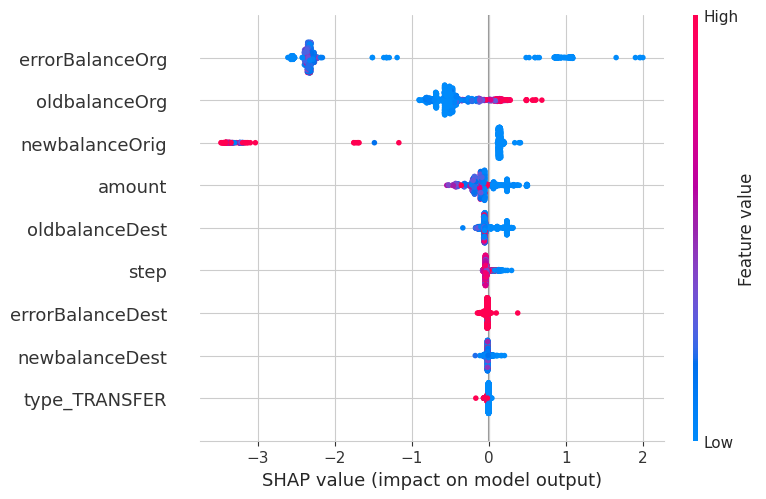


SHAP Force Plot (Prediksi Penipuan):
Plot ini menunjukkan bagaimana setiap fitur 'mendorong' prediksi dari nilai dasar ke output akhir.


In [16]:
if 'model' in locals():
    print("Menghitung nilai SHAP... Ini mungkin memakan waktu beberapa saat.")

    # Membuat explainer
    explainer = shap.TreeExplainer(model)

    # Menghitung nilai SHAP pada data pengujian (gunakan sampel untuk kecepatan)
    shap_values = explainer.shap_values(X_test.sample(n=1000, random_state=42))

    # Menggunakan sampel X_test yang sama untuk plot
    X_test_sample = X_test.sample(n=1000, random_state=42)

    # 1. SHAP Summary Plot
    print("\nSHAP Summary Plot:")
    print("Plot ini menunjukkan pentingnya setiap fitur. Setiap titik adalah satu prediksi. Warna menunjukkan nilai fitur (merah=tinggi, biru=rendah).")
    shap.summary_plot(shap_values, X_test_sample, plot_type="dot")

    # 2. SHAP Force Plot untuk satu prediksi penipuan
    print("\nSHAP Force Plot (Prediksi Penipuan):")
    print("Plot ini menunjukkan bagaimana setiap fitur 'mendorong' prediksi dari nilai dasar ke output akhir.")

    # --- PERBAIKAN ---
    # Inisialisasi Javascript untuk SHAP agar plot interaktif dapat ditampilkan
    shap.initjs()

    # Ambil indeks dari prediksi penipuan yang benar
    try:
        from IPython.display import display
        fraud_index = np.where((y_test == 1) & (y_pred == 1))[0][0]

        # --- PERBAIKAN UNTUK XGBOOST ERROR ---
        # Kita berikan DataFrame dengan satu baris (menggunakan double bracket)
        # untuk memastikan bentuk data (shape) tetap 2D.
        instance_to_explain = X_test.iloc[[fraud_index]]
        instance_shap_values = explainer.shap_values(instance_to_explain)

        # Tampilkan plot. Karena inputnya 2D, output shap_values juga 2D.
        # Kita ambil elemen pertama (indeks 0) untuk plot.
        display(shap.force_plot(
            explainer.expected_value,
            instance_shap_values[0],
            instance_to_explain.iloc[0]
        ))
    except IndexError:
        print("Tidak ditemukan contoh prediksi penipuan yang benar di set pengujian untuk di-plot.")
    except NameError:
        print("Fungsi 'display' tidak tersedia. Jalankan di lingkungan seperti Jupyter/Colab untuk melihat plot ini.")
    except Exception as e:
        print(f"Terjadi error saat membuat force plot: {e}")

# Studi Kasus SHAP

In [17]:
if 'model' in locals() and 'X_train' in locals():

    def analyze_transaction(transaction_data):
        """
        Fungsi untuk memprediksi dan menjelaskan sebuah transaksi tunggal.
        """
        # Buat DataFrame dari data transaksi
        new_transaction = pd.DataFrame([transaction_data])

        # Pastikan kolom 'type' ada untuk di-encode
        if 'type' in new_transaction.columns:
            # Lakukan one-hot encoding
            new_transaction['type_TRANSFER'] = 1 if new_transaction['type'].iloc[0] == 'TRANSFER' else 0
            new_transaction = new_transaction.drop('type', axis=1)

        # Hitung fitur rekayasa
        new_transaction['errorBalanceOrg'] = new_transaction['newbalanceOrig'] + new_transaction['amount'] - new_transaction['oldbalanceOrg']
        new_transaction['errorBalanceDest'] = new_transaction['oldbalanceDest'] + new_transaction['amount'] - new_transaction['newbalanceDest']

        # Pastikan urutan kolom sesuai dengan data pelatihan
        new_transaction = new_transaction[X_train.columns]

        # Prediksi
        prediction = model.predict(new_transaction)[0]
        prediction_proba = model.predict_proba(new_transaction)[0]

        print(f"Hasil Prediksi: {'PENIPUAN' if prediction == 1 else 'Bukan Penipuan'}")
        print(f"Probabilitas (Bukan Penipuan vs. Penipuan): {prediction_proba[0]:.2f} vs. {prediction_proba[1]:.2f}\n")

        # Penjelasan SHAP
        print("Penjelasan SHAP:")
        shap.initjs()
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(new_transaction)

        display(shap.force_plot(
            explainer.expected_value,
            shap_values[0],
            new_transaction.iloc[0]
        ))

    # --- Studi Kasus 1: Transaksi Mencurigakan ---
    # Skenario: Seluruh saldo akun yang besar ditransfer keluar, membuat saldo akhir menjadi 0.
    print("="*50)
    print("Studi Kasus 1: Transaksi Mencurigakan (Akun Dikuras)")
    print("="*50)
    suspicious_transaction = {
        'step': 10,
        'type': 'TRANSFER',
        'amount': 5000000.00,
        'oldbalanceOrg': 5000000.00,
        'newbalanceOrig': 0.00,
        'oldbalanceDest': 10000.00,
        'newbalanceDest': 5010000.00
    }
    analyze_transaction(suspicious_transaction)

    print("\n" + "="*50)
    print("Studi Kasus 2: Transaksi Normal (Cash Out Biasa)")
    print("="*50)
    # --- Studi Kasus 2: Transaksi Normal ---
    # Skenario: Pengambilan tunai (CASH_OUT) dalam jumlah wajar, saldo berkurang sesuai jumlah.
    normal_transaction = {
        'step': 15,
        'type': 'CASH_OUT',
        'amount': 150000.00,
        'oldbalanceOrg': 200000.00,
        'newbalanceOrig': 50000.00,
        'oldbalanceDest': 750000.00,
        'newbalanceDest': 900000.00
    }
    analyze_transaction(normal_transaction)

Studi Kasus 1: Transaksi Mencurigakan (Akun Dikuras)
Hasil Prediksi: PENIPUAN
Probabilitas (Bukan Penipuan vs. Penipuan): 0.05 vs. 0.95

Penjelasan SHAP:



Studi Kasus 2: Transaksi Normal (Cash Out Biasa)
Hasil Prediksi: Bukan Penipuan
Probabilitas (Bukan Penipuan vs. Penipuan): 0.93 vs. 0.07

Penjelasan SHAP:


# Export Model

In [18]:
import joblib
import os

# Coba impor dan mount Google Drive (ini hanya akan bekerja di Google Colab)
try:
    from google.colab import drive
    print("Memasang Google Drive...")
    drive.mount('/content/drive')

    # Tentukan folder target di Google Drive Anda
    target_dir = '/content/drive/MyDrive/Dicoding Capstone'
    print(f"Folder target diatur ke: {target_dir}")

    # Buat folder jika belum ada
    os.makedirs(target_dir, exist_ok=True)

except ImportError:
    print("Bukan lingkungan Google Colab. Model akan disimpan di folder lokal 'model_output'.")
    # Jika bukan Colab, simpan ke folder lokal
    target_dir = 'model_output'
    os.makedirs(target_dir, exist_ok=True)


if 'model' in locals() and 'X_train' in locals():
    # Tentukan path lengkap untuk file
    model_filename = os.path.join(target_dir, 'xgboost_model.joblib')
    columns_filename = os.path.join(target_dir, 'model_columns.joblib')

    # Simpan model XGBoost
    joblib.dump(model, model_filename)

    # Simpan daftar kolom yang digunakan saat pelatihan
    model_columns = list(X_train.columns)
    joblib.dump(model_columns, columns_filename)

    print(f"\n✅ Model berhasil disimpan sebagai: {model_filename}")
    print(f"✅ Kolom model berhasil disimpan sebagai: {columns_filename}")
    print("\nAnda sekarang siap untuk mendeploy!")

else:
    print("Error: Model ('model') atau data latih ('X_train') tidak ditemukan.")
    print("Pastikan Anda telah menjalankan Sel 4 terlebih dahulu.")


Memasang Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Folder target diatur ke: /content/drive/MyDrive/Dicoding Capstone

✅ Model berhasil disimpan sebagai: /content/drive/MyDrive/Dicoding Capstone/xgboost_model.joblib
✅ Kolom model berhasil disimpan sebagai: /content/drive/MyDrive/Dicoding Capstone/model_columns.joblib

Anda sekarang siap untuk mendeploy!
